## Import Packages

In [1]:
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
import matplotlib.pyplot as plt
import json
import datetime
from datetime import timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

## Import Data

In [2]:
#read the data from the json file
df = pd.read_json('logins.json')

In [3]:
#save file to memory
file = open("ultimate_data_challenge.json", "r")
dataset = file.read()
file.close()

#load file as JSON
data = json.loads(dataset)

#create df from JSON dataset
df = pd.DataFrame(data)

In [4]:
#parse dates
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"])
df["signup_date"] = pd.to_datetime(df["signup_date"])
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## Exploratory Data Analysis

In [5]:
#print out general statistics
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


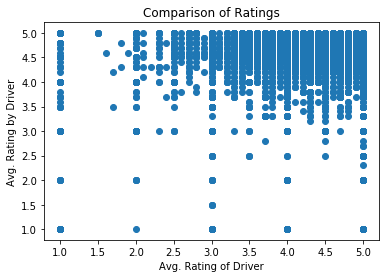

In [6]:
#compare the ratings given by passenger and the one given by the drive to see if there is a relationship
plt.scatter(df['avg_rating_of_driver'], df['avg_rating_by_driver'])
plt.xlabel('Avg. Rating of Driver')
plt.ylabel('Avg. Rating by Driver')
plt.title('Comparison of Ratings')
plt.show()

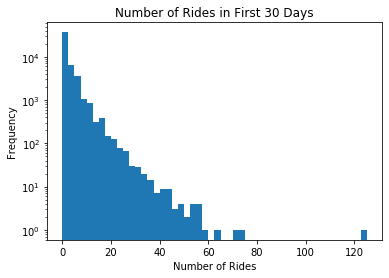

In [7]:
#plot distribution of the trips in the first 30 days
plt.hist(df['trips_in_first_30_days'], log = True, bins = 50)
plt.title('Number of Rides in First 30 Days')
plt.xlabel('Number of Rides')
plt.ylabel('Frequency')
plt.show()

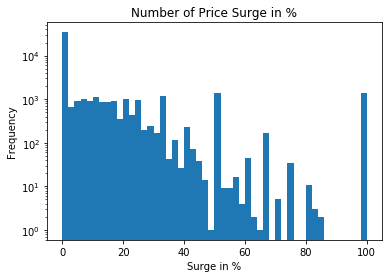

In [8]:
#plot distribution of the trips in the first 30 days
plt.hist(df['surge_pct'], log = True, bins = 50)
plt.title('Number of Price Surge in %')
plt.xlabel('Surge in %')
plt.ylabel('Frequency')
plt.show()

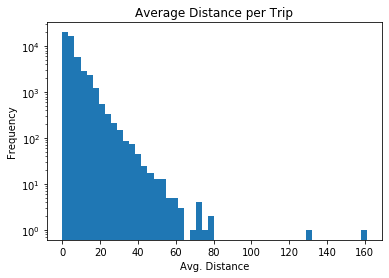

In [9]:
#plot distribution of the trips in the first 30 days
plt.hist(df['avg_dist'], log = True, bins = 50)
plt.title('Average Distance per Trip')
plt.xlabel('Avg. Distance')
plt.ylabel('Frequency')
plt.show()

## Define Active Users

In [10]:
#define active users: active users are defined as having taken a trip within the first 30 days after signup
active = lambda x: 1 if x != 0 else 0
df['active'] = df['trips_in_first_30_days'].apply(active)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1


In [11]:
#define users that were active after 5 months as an independent variable for the model
active_5M = lambda x: 1 if x['last_trip_date'] - x['signup_date'] > timedelta(days = 5*30) else 0
df['active_5M'] = df.apply(active_5M, axis = 1)

In [12]:
#active user stats
active_pct = len(df[df['active'] == 1])/len(df['active'])
inactive_pct = 1 - active_pct

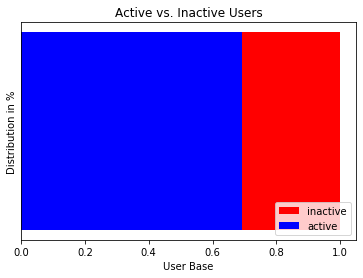

In [13]:
#stacked bar plot
plt.barh(y = 0, width = inactive_pct, left = active_pct, color = "red")
plt.barh(y = 0, width = active_pct, color = "blue")

#plot characteristics
plt.title("Active vs. Inactive Users")
plt.xlabel("User Base")
plt.ylabel("Distribution in %")
plt.yticks(ticks = [])
plt.legend(['inactive', 'active'], loc = 'lower right')
plt.show()

## Prepare Data for the Model

In [14]:
#dummy code categorical variables: phone, city
df = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'], drop_first = True)

In [15]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,active_5M,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,0,0,0,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,1,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,1,1,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,1,0,0,1,0,0


In [16]:
#drop the columns: signup_date, last_trip_date
df = df.drop(['signup_date', 'last_trip_date'], axis = 1)
columns = df.columns

#fill nan with imputer
imp = IterativeImputer(max_iter=10, random_state=0)
df = imp.fit_transform(df)

#normalize the data in the dataframe
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [17]:
#normalize the data in the dataframe
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [18]:
df = pd.DataFrame(df)
df.columns = columns
df

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,active_5M,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,0.032,0.868036,0.014286,0.154,0.462,0.022801,0.844634,1.0,0.0,1.0,0.0,1.0,1.0
1,0.000,0.938417,0.000000,0.000,0.500,0.051317,0.844634,0.0,0.0,0.0,0.0,0.0,0.0
2,0.024,0.774194,0.000000,0.000,1.000,0.004784,0.844634,1.0,0.0,0.0,0.0,1.0,0.0
3,0.072,0.844575,0.020000,0.200,0.800,0.014662,0.823518,1.0,1.0,1.0,0.0,1.0,1.0
4,0.112,0.797654,0.027143,0.118,0.824,0.019446,0.823518,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.000,0.938417,0.000000,0.000,1.000,0.034978,0.675707,0.0,0.0,1.0,0.0,1.0,0.0
49996,0.008,0.812239,0.000000,0.000,0.000,0.000000,0.633475,1.0,0.0,0.0,0.0,1.0,0.0
49997,0.000,0.938417,0.000000,0.000,1.000,0.023981,0.844634,0.0,0.0,0.0,1.0,0.0,1.0
49998,0.016,0.469208,0.000000,0.000,1.000,0.028454,0.527896,1.0,0.0,0.0,0.0,1.0,0.0


In [19]:
#define x and y
y = df['active_5M']
X = df.loc[:, df.columns != 'active_5M']

#split data in train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Train the Logic Regression

A logic regression model will be used, because it allows not only to forecast if a customer is likely to be an active user next month, but also how likely it is. This is very important, because it allows the company to focus marketing efforts on threshold candidates.

In [20]:
clf = LogisticRegression(penalty = 'l2', random_state = 0, fit_intercept = False, solver='liblinear')

#fit the model
model = clf.fit(X_train, y_train)

In [21]:
#print out the mean accuracy on the given test data and labels.
accuracy = clf.score(X_test, y_test)
print('the mean accuracy of the test set is:', accuracy)

the mean accuracy of the test set is: 0.7630303030303031


In [22]:
clf.coef_

array([[11.33080332, -0.85264685, -0.60703657,  0.32320585, -0.12645301,
        -5.46836713, -2.00243536, -0.23154904,  1.19503341,  0.38877136,
         0.85222743,  0.66616561]])

In [23]:
coefficients = clf.coef_[0]
coefficient_names = np.array(df.columns)
coefficient_names = np.delete(coefficient_names, 8)

In [24]:
df_coefficients = pd.DataFrame({'Name': coefficient_names, 'Coefficients': coefficients})

In [25]:
df_coefficients

,Name,Coefficients
0,trips_in_first_30_days,11.330803
1,avg_rating_of_driver,-0.852647
2,avg_surge,-0.607037
3,surge_pct,0.323206
4,weekday_pct,-0.126453
5,avg_dist,-5.468367
6,avg_rating_by_driver,-2.002435
7,active,-0.231549
8,city_King's Landing,1.195033
9,city_Winterfell,0.388771


In [26]:
#create a confusion matrix
y_pred = clf.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[11880   609]
 [ 3301   710]]


The confusion matrix shows, that we have TP: 11'880 + TN: 710 and thus 12'590 were classified correctly. In other words, 67.9% of the cases were classified correclty.

## Train the Random Forest Classifier

In [69]:
rfc = RandomForestClassifier(random_state=0)

In [70]:
param_grid_rfc = {
    'n_estimators': [50, 100],
    'criterion': ["gini", "entropy"],
    'max_depth': [5, 20, None],
    'max_features': [1, 5, 'sqrt', 'log2', None],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5],
}

In [71]:
clf = GridSearchCV(rfc, param_grid_rfc)

In [72]:
clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_gri

In [75]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [76]:
clf.best_score_

0.8

In [77]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 1,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [27]:
#refit the model
rfc = RandomForestClassifier(criterion = 'entropy', max_depth = 20, max_features = 1, min_samples_leaf = 3, min_samples_split = 2, n_estimators = 100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
#print out the mean accuracy on the given test data and labels.
accuracy = rfc.score(X_test, y_test)
print('the mean accuracy of the test set is:', accuracy)

the mean accuracy of the test set is: 0.796060606060606


In [29]:
#look at feature importance
feature_importance = rfc.feature_importances_

In [30]:
df_coefficients = pd.DataFrame({'Name': coefficient_names, 'Feature Importance': feature_importance})
df_coefficients

,Name,Feature Importance
0,trips_in_first_30_days,0.075257
1,avg_rating_of_driver,0.114628
2,avg_surge,0.086145
3,surge_pct,0.097948
4,weekday_pct,0.156766
5,avg_dist,0.198339
6,avg_rating_by_driver,0.124893
7,active,0.010012
8,city_King's Landing,0.046398
9,city_Winterfell,0.012106


## Model Comparison

A Random Forest Classifier is more accurate than a logistic regression, but it has the disadvantage that we can't interpret the coefficients. It is therefore difficult to make business decisions based on it.

## Data Leverage

There are several ways, Ultimate can use their data:
- identify which customers most likely remain clients and focus promotions on those that are in between
- the insights show that clients that use the service a lot in the first 30 days are likely to become long-term customers
- black users are more likely to stay, so they could try to improve customer experience on other rides too in order to increase the number of people from other categories that will turn into long-term customers